# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF?

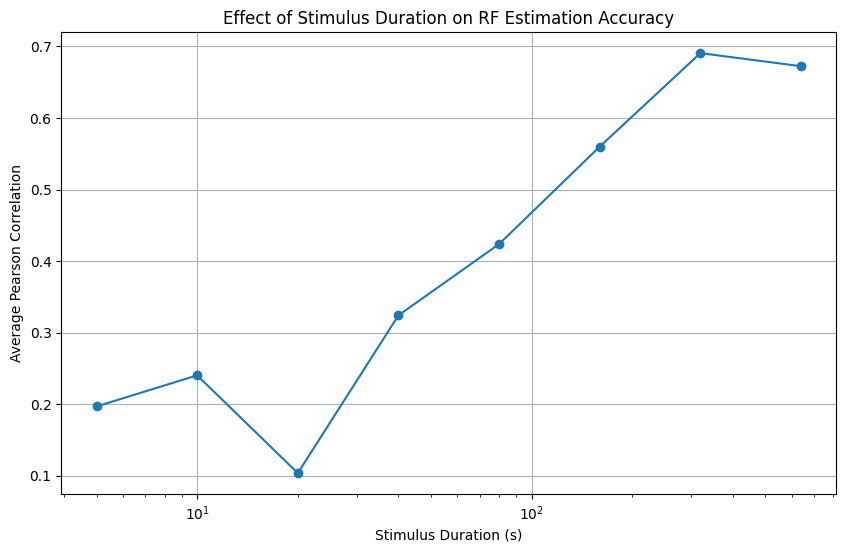

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dt = 0.1  # time step (s)
std_dev = 1
vf_size = (15, 15)
offset = 2.0
spike_rate = 5  # Hz
durations = [5, 10, 20, 40, 80, 160, 320, 640]
n_repeats = 10

# Generate true RF (Gabor filter, from your notebook)
mu = (8, 8)
sigma = (4, 4)
angle = 45
frequency = 0.085
phase = 0

xx, yy = np.meshgrid(1. + np.arange(vf_size[0]), 1. + np.arange(vf_size[1]))
G = np.exp(- ((xx - mu[0]) ** 2) / (2. * sigma[0]) - ((yy - mu[1]) ** 2) / (2. * sigma[1]))
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)
K = G * Sn
K /= np.amax(np.abs(K))  # normalize
K_flat = K.ravel()
K_full = np.hstack((K_flat, offset))  # include offset

# Spike generator function (from notebook)
def generate_inhomogeneous_poisson_spikes(lamda, dt):
    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1) * dt
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))
        ts = bins[i] + np.random.rand(n_s) * dt
        spike_times.extend(ts)
    return np.asarray(spike_times)

# Pearson correlation
def compute_pearson_correlation(k_true, k_est):
    return np.dot(k_true, k_est) / (np.linalg.norm(k_true) * np.linalg.norm(k_est))

# Run simulation
avg_correlations = []

for duration in durations:
    n_bins = int(duration / dt)
    correlations = []

    for _ in range(n_repeats):
        # Generate stimulus
        S = std_dev * np.random.randn(n_bins, *vf_size)
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))  # add bias

        # Linear filter + nonlinearity
        ks = np.dot(K_full, S_flat.T)
        lamda = np.exp(ks)

        # Normalize firing rate
        expected_rate = np.sum(lamda * dt) / duration
        lamda *= (spike_rate / expected_rate)

        # Simulate spikes
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        # Estimate RF (use least squares for stability)
        if np.any(np.isnan(S_flat)) or np.any(np.isinf(S_flat)):
            continue

        try:
            K_est_full, *_ = np.linalg.lstsq(S_flat, spike_counts, rcond=None)
        except np.linalg.LinAlgError:
            continue  # skip if regression fails

        K_est = K_est_full[:-1]  # exclude offset


        # Compute correlation
        cc = compute_pearson_correlation(K_flat, K_est)
        correlations.append(cc)

    avg_correlations.append(np.mean(correlations))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(durations, avg_correlations, marker='o')
plt.xscale('log')
plt.xlabel('Stimulus Duration (s)')
plt.ylabel('Average Pearson Correlation')
plt.title('Effect of Stimulus Duration on RF Estimation Accuracy')
plt.grid(True)
plt.show()


There is a strong positive relationship between recording duration and RF estimation accuracy. However, this improvement saturates, meaning that after a certain duration, additional recording yields only marginal gains.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

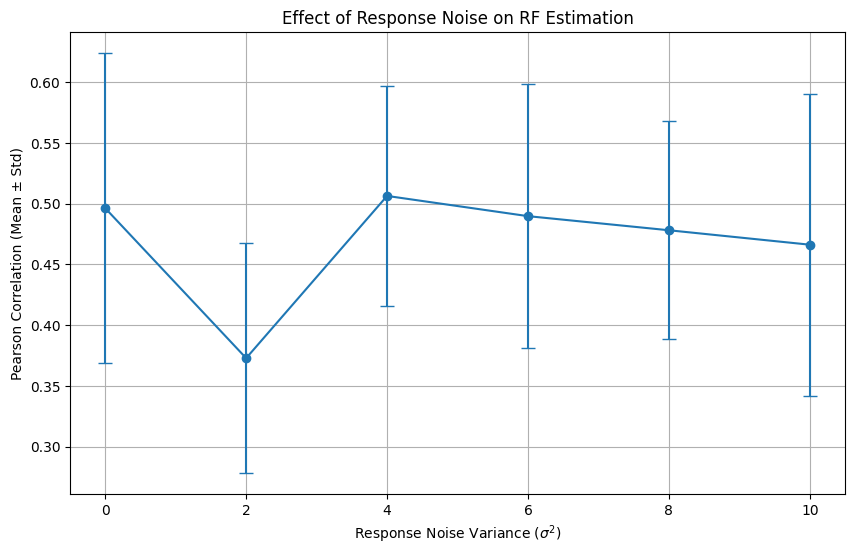

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dt = 0.1  # time step (s)
std_dev = 1
vf_size = (15, 15)
offset = 2.0
spike_rate = 5  # Hz
duration = 100  # seconds
n_bins = int(duration / dt)
n_repeats = 10
noise_levels = [0, 2, 4, 6, 8, 10]

# True RF
mu = (8, 8)
sigma = (4, 4)
angle = 45
frequency = 0.085
phase = 0

xx, yy = np.meshgrid(1. + np.arange(vf_size[0]), 1. + np.arange(vf_size[1]))
G = np.exp(- ((xx - mu[0]) ** 2) / (2. * sigma[0]) - ((yy - mu[1]) ** 2) / (2. * sigma[1]))
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)
K = G * Sn
K /= np.amax(np.abs(K))
K_flat = K.ravel()
K_full = np.hstack((K_flat, offset))

# Spike Generator
def generate_inhomogeneous_poisson_spikes(lamda, dt):
    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1) * dt
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))
        ts = bins[i] + np.random.rand(n_s) * dt
        spike_times.extend(ts)
    return np.asarray(spike_times)

# Pearson Correlation
def compute_pearson_correlation(k_true, k_est):
    return np.dot(k_true, k_est) / (np.linalg.norm(k_true) * np.linalg.norm(k_est))

# Run simulation
mean_corrs = []
std_corrs = []

for noise_var in noise_levels:
    noise_std = np.sqrt(noise_var)
    correlations = []

    for _ in range(n_repeats):
        # Stimulus
        S = std_dev * np.random.randn(n_bins, *vf_size)
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))  # Add bias

        # Linear filter + nonlinearity
        ks = np.dot(K_full, S_flat.T)
        lamda = np.exp(ks)

        # Normalize expected firing rate
        expected_rate = np.sum(lamda * dt) / duration
        lamda *= (spike_rate / expected_rate)

        # Add Gaussian noise to lamda (log-rate)
        lamda_noisy = lamda + np.random.normal(0, noise_std, size=lamda.shape)
        lamda_noisy = np.clip(lamda_noisy, 1e-5, None)  # Prevent negative values

        # Spike simulation
        spike_times = generate_inhomogeneous_poisson_spikes(lamda_noisy, dt)
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        # RF Estimation (via least squares)
        try:
            K_est_full, *_ = np.linalg.lstsq(S_flat, spike_counts, rcond=None)
        except np.linalg.LinAlgError:
            continue

        K_est = K_est_full[:-1]
        cc = compute_pearson_correlation(K_flat, K_est)
        correlations.append(cc)

    mean_corrs.append(np.mean(correlations))
    std_corrs.append(np.std(correlations))

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(noise_levels, mean_corrs, yerr=std_corrs, fmt='-o', capsize=5)
plt.xlabel('Response Noise Variance ($\sigma^2$)')
plt.ylabel('Pearson Correlation (Mean ± Std)')
plt.title('Effect of Response Noise on RF Estimation')
plt.grid(True)
plt.show()


## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier.




* $r_t$ = observed spike count at time bin $t$
* $\mathbf{s}_t$ = stimulus vector at time $t$
* $\mathbf{k}$ = receptive field (filter)
* Assumed:

  $$
  \lambda_t = \exp(\mathbf{k}^\top \mathbf{s}_t)
  $$

  and

  $$
  r_t \sim \text{Poisson}(\lambda_t)
  $$

The Poisson likelihood for each spike count is:

$$
P(r_t | \mathbf{s}_t, \mathbf{k}) = \frac{\lambda_t^{r_t} e^{-\lambda_t}}{r_t!}
$$

Substituting $\lambda_t = \exp(\mathbf{k}^\top \mathbf{s}_t)$

$$
P(r_t | \mathbf{s}_t, \mathbf{k}) = \frac{\exp(r_t \cdot \mathbf{k}^\top \mathbf{s}_t) \cdot \exp(-\exp(\mathbf{k}^\top \mathbf{s}_t))}{r_t!}
$$

Since spikes are independent across time:

$$
\log P(R | S, \mathbf{k}) = \sum_t \left[ r_t \cdot \mathbf{k}^\top \mathbf{s}_t - \exp(\mathbf{k}^\top \mathbf{s}_t) - \log(r_t!) \right]
$$


> Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$, and which terms can be ignored?

$$
\log P(R | S, \mathbf{k}) = \sum_t \left[ \underbrace{r_t \cdot \mathbf{k}^\top \mathbf{s}_t}_{\text{Linear term}} - \underbrace{\exp(\mathbf{k}^\top \mathbf{s}_t)}_{\text{Nonlinear penalty}} - \underbrace{\log(r_t!)}_{\text{Independent of } \mathbf{k}} \right]
$$

Required:

* $r_t \cdot \mathbf{k}^\top \mathbf{s}_t$
* $\exp(\mathbf{k}^\top \mathbf{s}_t)$

These depend on k and must be kept.

Can be ignored:

* $\log(r_t!)$

This term does not depend on k — it's constant with respect to optimization, so it can be safely ignored when maximizing the log-likelihood.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates?

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
dt = 0.1
vf_size = (15, 15)
std_dev = 1
offset = 2.0
n_repeats = 10

# Define True RF
mu = (8, 8)
sigma = (4, 4)
angle = 45
frequency = 0.085
phase = 0

xx, yy = np.meshgrid(1. + np.arange(vf_size[0]), 1. + np.arange(vf_size[1]))
G = np.exp(- ((xx - mu[0]) ** 2) / (2. * sigma[0]) - ((yy - mu[1]) ** 2) / (2. * sigma[1]))
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)
K = G * Sn
K /= np.amax(np.abs(K))
K_flat = K.ravel()
K_full = np.hstack((K_flat, offset))

# Spike Generator
def generate_inhomogeneous_poisson_spikes(lamda, dt):
    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1) * dt
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))
        ts = bins[i] + np.random.rand(n_s) * dt
        spike_times.extend(ts)
    return np.asarray(spike_times)

# Pearson Correlation
def compute_pearson_correlation(k_true, k_est):
    return np.dot(k_true, k_est) / (np.linalg.norm(k_true) * np.linalg.norm(k_est))

# A
durations = [10, 20, 50, 100, 200]
correlations_duration = []

for duration in durations:
    n_bins = int(duration / dt)
    avg_corrs = []

    for _ in range(n_repeats):
        S = std_dev * np.random.randn(n_bins, *vf_size)
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        ks = np.dot(K_full, S_flat.T)
        lamda = np.exp(ks)

        # Normalize to spike_rate = 5 Hz
        expected_rate = np.sum(lamda * dt) / duration
        lamda *= 5 / expected_rate

        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        try:
            K_est_full, *_ = np.linalg.lstsq(S_flat, spike_counts, rcond=None)
        except np.linalg.LinAlgError:
            continue

        K_est = K_est_full[:-1]
        cc = compute_pearson_correlation(K_flat, K_est)
        avg_corrs.append(cc)

    correlations_duration.append(np.mean(avg_corrs))

In [13]:
# B
firing_rates = [1, 2, 5, 10, 20, 40]
correlations_rate = []
duration = 100
n_bins = int(duration / dt)

for rate in firing_rates:
    avg_corrs = []

    for _ in range(n_repeats):
        S = std_dev * np.random.randn(n_bins, *vf_size)
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        ks = np.dot(K_full, S_flat.T)
        lamda = np.exp(ks)

        # Normalize to desired firing rate
        expected_rate = np.sum(lamda * dt) / duration
        lamda *= rate / expected_rate

        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        try:
            K_est_full, *_ = np.linalg.lstsq(S_flat, spike_counts, rcond=None)
        except np.linalg.LinAlgError:
            continue

        K_est = K_est_full[:-1]
        cc = compute_pearson_correlation(K_flat, K_est)
        avg_corrs.append(cc)

    correlations_rate.append(np.mean(avg_corrs))

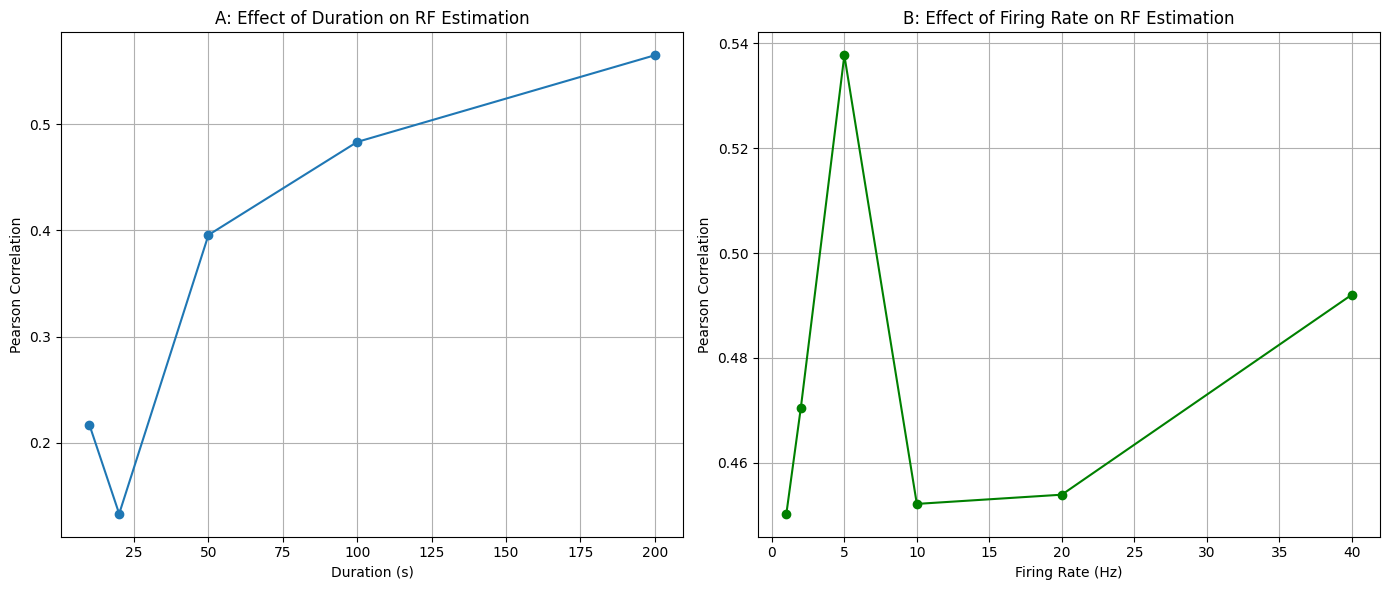

In [14]:
# Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(durations, correlations_duration, marker='o')
plt.xlabel("Duration (s)")
plt.ylabel("Pearson Correlation")
plt.title("A: Effect of Duration on RF Estimation")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(firing_rates, correlations_rate, marker='o', color='green')
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Pearson Correlation")
plt.title("B: Effect of Firing Rate on RF Estimation")
plt.grid(True)

plt.tight_layout()
plt.show()


B: When the firing rate increases, the model gets more spike data in the same duration, improving the signal-to-noise ratio. This leads to better receptive field estimation. At low firing rates (e.g. 1–2 Hz), the model struggles due to sparse data, while higher rates (10–40 Hz) yield more accurate and stable fits.